In [1]:
import os

import tensorflow as tf
import tensorflow.keras as keras

from keras_cv_attention_models import beit, convnext, swin_transformer_v2, davit, mobilevit, coatnet

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from collections import defaultdict
from tabulate import tabulate
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

from datetime import datetime
from time import time
import pytz


In [15]:
# orig_folder = "../datasets/original"
exp_folder = "./experiment"

# orig_dataset1 = os.path.join(orig_folder, "1")
# orig_dataset2 = os.path.join(orig_folder, "2/Training-validation")
# orig_dataset3 = os.path.join(orig_folder, "3")

exp_dataset1 = os.path.join(exp_folder, "1")
exp_dataset2 = os.path.join(exp_folder, "2")
exp_dataset3 = os.path.join(exp_folder, "3")

exp_dataset4 = os.path.join(exp_folder, "4")
exp_dataset6 = os.path.join(exp_folder, "6")
exp_dataset7 = os.path.join(exp_folder, "7")
exp_dataset8 = os.path.join(exp_folder, "8")
exp_dataset9 = os.path.join(exp_folder, "9")

CLASS_NAMES = ['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']

RANDOM_STATE = 42

randomiser = np.random.RandomState(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
# keras.utils.set_random_seed(RANDOM_STATE)

def timer(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [7]:
"""
Takes a model and adjusts its output layer and trainable layers
"""
def get_model(base_model, num_outputs, extra_layer=False, num_trainable=0):
#     removes the original output layer
    penultimate_layer = base_model.layers[-2].output
    
    output = keras.layers.Dense(units=num_outputs, activation='softmax')(penultimate_layer)
    
#     adds an extra hidden layer with 128 neurons and a linear activation
    if extra_layer:
        dense_layer1 = keras.layers.Dense(units=128, activation='linear')(penultimate_layer)

        output = keras.layers.Dense(units=num_outputs, activation='softmax')(dense_layer1)
        
    base_model = keras.models.Model(inputs=base_model.input, outputs=output)
    
#     make the last num_trainable layers trainable, i.e., 5 will keep the last 5 layers 
#     trainable and freeze the rest
#     if num_trainable = 0, all layers are trainable
    for layers in base_model.layers[:-num_trainable]:
        layers.trainable = False
        

    return base_model

In [8]:
"""
Gets the dataset to use for training, validation and testing
"""
classes_needed = {
    1: ['normal', 'ome'],
    2: [],
    3: ['normal', 'tube']
}

def get_dataset(paths, class_names):
    full_data = []
    class_dict = {}
    for i, name in enumerate(class_names):
        class_dict[name] = i
    

    
    for path in paths:
        print(path)
        dataset = path.split('/')
    
#         print(dataset[2])
#         return
    
        for d in class_names:
#             if d not in classes_needed[int(dataset[2])]: continue
            dirpath = os.path.join(path, d)
            if not os.path.exists(dirpath): continue
            print(dirpath)
            image_files = [f for f in os.listdir(dirpath) if f.endswith(('.jpg', '.png', 'jpeg'))]
            label = d
            for img in image_files:
                image = Image.open(os.path.join(dirpath, img))
                
                image = np.asarray(image).astype(np.float32) / 255.0

                data = np.array([image, class_dict[label]], dtype=object)
                full_data.append(data)
    
    full_data = np.array(full_data)
    np.random.shuffle(full_data)
    return full_data

In [9]:
def resize_image(image, size):
    image = tf.image.resize(image.astype(np.float32), (size, size))
    return image

In [11]:
base_path = exp_dataset4

print(base_path)


class_names = CLASS_NAMES

class_dict = {
    1: 'normal',
    2: 'aom',
    3: 'ome',
    4: 'csom',
    5: 'myringosclerosis',
    6: 'earwax',
    7: 'tube'
}

# classes = [1, 4, 5, 6]
classes = [2, 7]

classes = [1, 2, 3, 4, 5, 6, 7]

# classes = [1, 3, 7]

class_names = [class_dict[i] for i in classes]



training_set = []
validation_set = []
testing_set = []

# For Experiments 1-3
if not base_path == exp_dataset4:
#     checks which classes are in the dataset being used
    class_names = [c for c in CLASS_NAMES if c in os.listdir(os.path.join(base_path, 'training'))]

    training_set = get_dataset([os.path.join(base_path, 'training')], class_names)
    validation_set = get_dataset([os.path.join(base_path, 'validation')], class_names)
    testing_set = get_dataset([os.path.join(base_path, 'testing')], class_names)

else:
#     change start and end to train on a subset of the combined dataset
    start = 1
    end = 4
    base_path = "./experiment"
    train_paths = [os.path.join(base_path, f'{i}/training') for i in range(start, end)]
    validation_paths = [os.path.join(base_path, f'{i}/validation') for i in range(start, end)]
    test_paths = [os.path.join(base_path, f'{i}/testing') for i in range(start, end)]
    
    print(class_names)
    training_set = get_dataset(train_paths, class_names)
    validation_set = get_dataset(validation_paths, class_names)
    testing_set = get_dataset(test_paths, class_names)   

./experiment/4
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
./experiment/1/training
./experiment/1/training/normal
./experiment/1/training/ome
./experiment/1/training/tube
./experiment/2/training
./experiment/2/training/normal
./experiment/2/training/csom
./experiment/2/training/myringosclerosis
./experiment/2/training/earwax
./experiment/3/training
./experiment/3/training/normal
./experiment/3/training/aom
./experiment/3/training/csom
./experiment/3/training/myringosclerosis
./experiment/3/training/earwax
./experiment/3/training/tube
./experiment/1/validation
./experiment/1/validation/normal
./experiment/1/validation/ome
./experiment/1/validation/tube
./experiment/2/validation
./experiment/2/validation/normal
./experiment/2/validation/csom
./experiment/2/validation/myringosclerosis
./experiment/2/validation/earwax
./experiment/3/validation
./experiment/3/validation/normal
./experiment/3/validation/aom
./experiment/3/validation/csom
./experiment/3/validation/m

In [12]:
# Separate the full data containing images and labels inside tuples into a train and test set

X_train = np.array([x[0] for x in training_set], dtype=object)
y_train = np.array([y[1] for y in training_set], dtype=np.uint8)

X_val = np.array([x[0] for x in validation_set], dtype=object)
y_val = np.array([y[1] for y in validation_set], dtype=np.uint8)

X_test = np.array([x[0] for x in testing_set], dtype=object)
y_test = np.array([y[1] for y in testing_set], dtype=np.uint8)

In [13]:
# Used to check the sample size for the different classes
print(class_names)
print(np.bincount(y_train))
print(np.bincount(y_val))
print(np.bincount(y_test))

print(sum(np.bincount(y_train)))

['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[653  83 125 198 174 252  78]
[93 11 18 28 25 36 11]
[188  25  36  57  49  72  23]
1563


In [16]:
# different variables based on input size and pretrain dataset

input_shape224 = (224, 224, 3)
input_shape256 = (256, 256, 3)
input_shape384 = (384, 384, 3)

imagenet = "imagenet"
imagenet21k = 'imagenet21k-ft1k'
imagenet22k = 'imagenet22k'

# loads and stores the base models
base_models = {
#     'convBase': convnext.ConvNeXtBase(input_shape=input_shape224, pretrained=imagenet21k),
    'daViT_B': davit.DaViT_B(input_shape224, pretrained=imagenet),
#     'MobileViT_S': mobilevit.MobileViT_S(input_shape=input_shape256, pretrained=imagenet),
#     'vgg19': tf.keras.applications.VGG19(
#         include_top=True,
#         weights=imagenet,
#         classifier_activation="softmax",
#     )
#     'daViT_T': davit.DaViT_T(input_shape224, pretrained=imagenet)

}

# the models to traain
# base models are modified by changing trainable or output layers
models = [
#     ('MobileViT_S', get_model(base_models['MobileViT_S'], len(class_names), True, 0)),
#     ('vgg19', get_model(base_models['vgg19'], len(class_names), True, 0)),
    ('daViT_B', get_model(base_models['daViT_B'], len(class_names), True, 0)),
#     ('daViT_T', get_model(base_models['daViT_T'], len(class_names), True, 0)),
#     ('convBase', get_model(base_models['convBase'], len(class_names), True, 0))
    
]

>>>> Load pretrained from: /home/ubuntu/.keras/models/davit_b_imagenet.h5


In [17]:
# sets the folder to save the models to based on the dataset being used
model_base_folders = {
    exp_dataset1: './models/1',
    exp_dataset2: './models/2',
    exp_dataset3: './models/3',
    exp_dataset4: './models/4',
    exp_dataset6: './models/6',
    exp_dataset7: './models/7',
    exp_dataset8: './models/8',
    exp_dataset9: './models/9'
    
}

base_path = exp_dataset9

model_base_folder = model_base_folders[base_path]

# model_base_folder = os.path.join(model_base_folder, "d3")


print(model_base_folder)

./models/9


In [18]:
# note: for demonstration purposes, I have trained four test models for 1 epoch

histories = []

# chosen hyperparameters for training
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.001

"""
Trains the models and saves the history
Saves only the best weights of the model by using call backs
"""

for m in models:
    model_name = m[0]
    model = m[1]
    
#     resizes images based on input size
    img_size = model.layers[0].input_shape[0][1]
    X_train2 = np.array([resize_image(x, img_size) for x in X_train])
    X_val2 = np.array([resize_image(x, img_size) for x in X_val])
    X_test2 = np.array([resize_image(x, img_size) for x in X_test])
    
#     early stopping callback to stop training if model is not improving
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.0001,
        patience=10,
        verbose=1,
        mode="min",
        restore_best_weights=True
    )

    # To frequently save the best model while training so progress is not lost
    model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
        filepath=f"{model_base_folder}/{model_name}", 
        monitor='val_loss',
        mode="min",
        save_best_only=True
    )
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # compiling the model to use for training
    opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
    model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
    callbacks = [early_stopping, model_checkpoint_cb]
    
#     if validation test size is 0, use test set for validation
    val_X = X_val2 if len(X_val2) > 0 else X_test2
    val_y = y_val if len(X_val2) > 0 else y_test
    
#     train the model and store the results in history
    history = model.fit(X_train2, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_X, val_y),  
                        callbacks=callbacks, verbose=True)
    
#     save the history into a file with the same name as the model
    np.save(f"{model_base_folder}/{model_name}.npy",history.history)
    histories.append(history.history)
    

Epoch 1/50
98/98 [==============================] - 129s 976ms/step - loss: 1.7564 - accuracy: 0.3769 - val_loss: 1.5403 - val_accuracy: 0.4324
INFO:tensorflow:Assets written to: ./models/9/daViT_B/assets
Epoch 2/50
98/98 [==============================] - 91s 929ms/step - loss: 1.5249 - accuracy: 0.4496 - val_loss: 1.4541 - val_accuracy: 0.5180
INFO:tensorflow:Assets written to: ./models/9/daViT_B/assets
Epoch 3/50
98/98 [==============================] - 91s 929ms/step - loss: 1.4265 - accuracy: 0.4983 - val_loss: 1.3737 - val_accuracy: 0.5315
INFO:tensorflow:Assets written to: ./models/9/daViT_B/assets
Epoch 4/50
98/98 [==============================] - 91s 929ms/step - loss: 1.3150 - accuracy: 0.5659 - val_loss: 1.2409 - val_accuracy: 0.5766
INFO:tensorflow:Assets written to: ./models/9/daViT_B/assets
Epoch 5/50
98/98 [==============================] - 91s 929ms/step - loss: 1.1585 - accuracy: 0.6258 - val_loss: 1.1676 - val_accuracy: 0.6351
INFO:tensorflow:Assets written to: ./mod

In [19]:
"""
Takes the history from training the model and graphs accuracy vs epoch and loss vs epoch
"""
def draw_graph(history):

    if 'history' in history:
        history = history.history
        
    plt.figure(figsize=(8,5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    best_epoch = np.argmin(history['val_loss'])
    
    plt.axvline(x=best_epoch, color='r', linestyle='--')
    plt.text(min(best_epoch+1, 38), 0.7, f"best epoch = {best_epoch}")

    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    best_epoch = np.argmin(history['val_loss'])
    
    
    plt.axvline(x=best_epoch, color='r', linestyle='--')
    plt.text(min(best_epoch+1, 38), 0.9, f"best epoch = {best_epoch}")


In [20]:
"""
Compute the statistics, binary accuracy, accuracy, sensitivity, specificity and ppv
Used to check statistics right after training
"""

def get_metrics(matrix):
    b_acc = []
    acc = []
    sens = []
    spec = []
    ppv = []

    for i, c in enumerate(class_names[:len(matrix)]):
        TP = matrix[i][i]
        FN = matrix.sum(axis=1)[i] - TP
        FP = matrix.sum(axis=0)[i] - TP
        TN = matrix.sum() - TP - FN - FP
        
        # Only use classes with a support greater than 0
        if (matrix.sum(axis=1)[i]) < 1: continue

        b_acc.append((TP+TN) / (TP+FN+FP+TN))
        acc.append((TP) / (TP+FN+FP+TN))
        sens.append((TP) / (TP+FN))
        spec.append((TN) / (TN+FP))
        ppv.append((TP) / (TP + FP))

    print(np.nanmean(b_acc))
    print(np.sum(acc))
    print(np.nanmean(sens))
    print(np.nanmean(spec))
    print(np.nanmean(ppv))
    f1 = 2*(np.nanmean(ppv)*np.nanmean(sens) / (np.nanmean(ppv) + np.nanmean(sens)))
    print(f1)

In [21]:
"""
Show the statistics of the model
Shows the confusion matrics and the selected metrics
Note: the model may not have the best weights as model weights are overwritten every epoch
Use statistics file and load the model and test to get more accurate results
"""

def show_statistics(model, X_test=X_test, y_test=y_test):
    # predict on the testing set to obtain a probability for each class
    y_pred=model.predict(X_test)
    
#     Uncomment to see the top-2 accuracy probability and value
#     print(top_k_accuracy_score(y_test, y_pred, k=2))
#     print(top_k_accuracy_score(y_test, y_pred, k=2, normalize=False))
    
        # use the highest probability to obtain the actual prediction
    y_pred=np.argmax(y_pred,axis=1)
    
    # display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    names = [class_names[i] for i in sorted(np.unique(y_test))]
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=names)
    
    plt.rcParams["figure.figsize"] = (5,5)
    disp.plot(cmap="Greys", xticks_rotation="vertical")
    
    # Print table of metrics and evaluations
    print(classification_report(y_test, y_pred, target_names=names, zero_division=0))
    
    # Show model summary
#     model.summary()
    get_metrics(cm)


                  precision    recall  f1-score   support

          normal       0.89      0.90      0.90       188
             aom       0.64      0.72      0.68        25
             ome       0.92      0.97      0.95        36
            csom       0.98      0.81      0.88        57
myringosclerosis       0.81      0.88      0.84        49
          earwax       0.87      0.92      0.89        72
            tube       1.00      0.83      0.90        23

        accuracy                           0.88       450
       macro avg       0.87      0.86      0.86       450
    weighted avg       0.89      0.88      0.88       450

0.9657142857142856
0.88
0.8597829399844581
0.9769930174262347
0.8737935543171235
0.8667316308680296


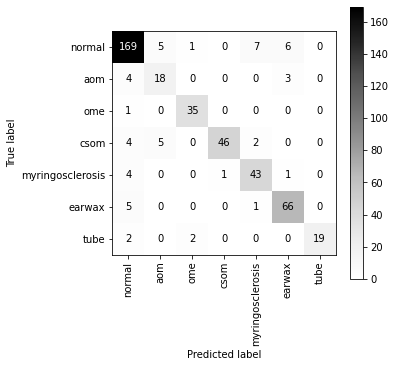

<Figure size 576x360 with 0 Axes>

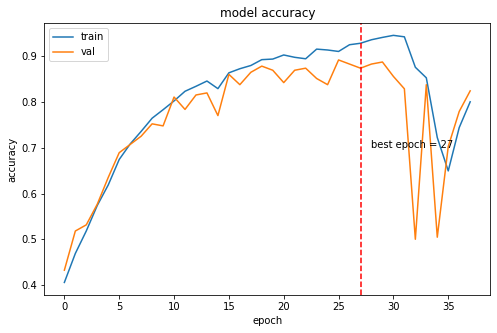

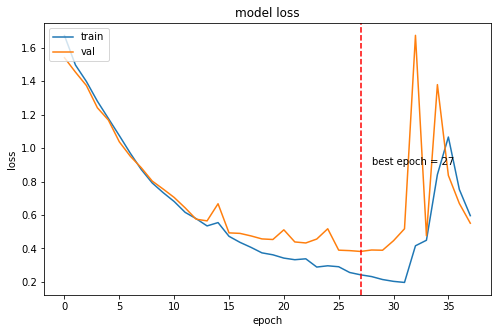

In [22]:
# shows the graph and history of the models that were trained
for i, m in enumerate(models[:1]):
    img_size = m[1].layers[0].input_shape[0][1] 
    X_test2 = np.array([resize_image(x, img_size) for x in X_test])
    
    show_statistics(m[1], X_test2, y_test)
    plt.figure(figsize=(8,5))
    draw_graph(histories[i])
    